In [62]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from prysm.interferogram import Interferogram
from skimage.restoration import unwrap_phase
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from scipy.ndimage import label
from scipy.spatial.distance import euclidean
from skimage.measure import regionprops
from prysm.geometry import circle # can be used to isolate apertures on interferogramm

In [63]:
def load_image_grayscale(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return img.astype(np.float32) / 255.0

def scale_phase(phase, factor = 2*np.pi):
    valid = ~np.isnan(phase)
    norm = (phase - 0.5*factor) / factor
    norm[~valid] = np.nan

    return norm

def apply_elliptical_mask(img, fill_value=np.nan, a=0.96, b=0.96):
    """
    Applies an elliptical mask to an image.

    Parameters:
        img (ndarray): 2D grayscale input image.
        fill_value: Value to use outside the mask (default: np.nan).
        a (float): Semi-major axis (horizontal), normalized (0 < a <= 1).
        b (float): Semi-minor axis (vertical), normalized (0 < b <= 1).

    Returns:
        masked_img (ndarray): Image with fill_value outside ellipse.
        mask (ndarray): Binary mask used (1 inside, 0 outside).
    """
    h, w = img.shape
    Y, X = np.indices((h, w))
    cx, cy = w / 2, h / 2
    norm_x = (X - cx) / (a * w / 2)
    norm_y = (Y - cy) / (b * h / 2)
    ellipse = norm_x**2 + norm_y**2 <= 1

    masked_img = np.full_like(img, fill_value, dtype=np.float32)
    masked_img[ellipse] = img[ellipse]

    return masked_img, ellipse.astype(np.uint8)

In [64]:
def remove_tilt(phase, mask=None):
    """
    Remove best-fit plane (tilt) from a 2D phase map.
    Optionally use a binary mask to limit fitting to ROI (e.g., circular aperture).
    """
    h, w = phase.shape
    Y, X = np.indices((h, w))
    X = X.ravel()
    Y = Y.ravel()
    Z = phase.ravel()

    if mask is not None:
        mask = mask.ravel()
        X = X[mask > 0]
        Y = Y[mask > 0]
        Z = Z[mask > 0]

    # Fit plane: Z = ax + by + c
    A = np.c_[X, Y, np.ones_like(X)]
    C, _, _, _ = np.linalg.lstsq(A, Z, rcond=None)
    plane = (C[0] * np.arange(w)[None, :] +
             C[1] * np.arange(h)[:, None] +
             C[2])
    return phase - plane

def add_defocus(phase, D):
    """
    Introduce defocus D into a 2D phase map.
    """
    h, w = phase.shape
    Y, X = np.indices((h, w))
    X = X.ravel() - w // 2
    Y = Y.ravel() - h // 2
    D = 4 * D / max(w, h)**2
    Z = phase.ravel() + D * (X**2 + Y**2)
    phase = Z.reshape((h, w))

    return phase

In [65]:
def fft_filter_manual(
    img,
    mask_shape='ellipse',
    center=(0, 0),
    size=(0.1, 0.1),
    angle=0,
    invert = False
):
    """
    FFT filtering with correctly constructed frequency grid and rotated mask.

    Parameters:
        img (ndarray): Input image, may contain NaNs.
        mask_shape (str): 'ellipse' or 'rectangle'.
        center (tuple): (fx, fy) center, from -1 to 1 (normalized).
        size (tuple): (width, height) in normalized units (0–2).
        angle (float): Rotation angle in degrees (CCW).

    Returns:
        img_filtered (ndarray): Filtered image.
        log_spectrum_before (ndarray): Log magnitude before masking.
        log_spectrum_after (ndarray): Log magnitude after masking.
    """
    # Handle NaNs
    img_filled = img.copy()
    nan_mask = np.isnan(img_filled)
    img_filled[nan_mask] = np.nanmean(img_filled)

    h, w = img.shape

    # Build centered, symmetric frequency grid
    y = np.linspace(-1, 1, h, endpoint=False)
    x = np.linspace(-1, 1, w, endpoint=False)
    FX, FY = np.meshgrid(x, y, indexing='xy')  # Note: FX goes along cols, FY along rows

    # Compute FFT and log amplitude spectrum
    F = fftshift(fft2(img_filled))
    log_spectrum_before = np.log1p(np.abs(F))

    # Translate to mask center
    FXc = FX - center[0]
    FYc = FY - center[1]

    # Rotate
    theta = np.deg2rad(angle)
    FXr = FXc * np.cos(theta) + FYc * np.sin(theta)
    FYr = -FXc * np.sin(theta) + FYc * np.cos(theta)

    # Build mask
    if mask_shape == 'ellipse':
        mask = ((FXr / (size[0] / 2)) ** 2 + (FYr / (size[1] / 2)) ** 2) <= 1
    elif mask_shape == 'rectangle':
        mask = (np.abs(FXr) <= size[0] / 2) & (np.abs(FYr) <= size[1] / 2)
    else:
        raise ValueError("mask_shape must be 'ellipse' or 'rectangle'")

    if invert:
        mask = ~mask

    # Apply mask
    F_filtered = F * mask
    log_spectrum_after = np.log1p(np.abs(F_filtered))

    # Inverse FFT
    img_filtered = np.angle(ifft2(ifftshift(F_filtered)))
    
    # unwrap phase
    img_filtered = unwrap_phase(img_filtered)
    
    # restore NaNs
    img_filtered[nan_mask] = np.nan

    return img_filtered, log_spectrum_before, log_spectrum_after


In [90]:

def fft_filter_manual_multy(
    img,
    mask_params_list
):
    """
    FFT filtering with support for multiple masks.

    Parameters:
        img (ndarray): Input image, may contain NaNs.
        mask_params_list (list of dict): Each dict with keys:
            - 'mask_shape': 'ellipse' or 'rectangle'
            - 'center': (fx, fy) in normalized units [-1, 1]
            - 'size': (width, height) in normalized units [0–2]
            - 'angle': rotation angle in degrees (CCW)
            - 'invert': bool, whether to invert this mask

    Returns:
        img_filtered (ndarray): Filtered, unwrapped phase image.
        log_spectrum_before (ndarray): Log spectrum before masking.
        log_spectrum_after (ndarray): Log spectrum after masking.
    """
    img_filled = img.copy()
    nan_mask = np.isnan(img_filled)
    img_filled[nan_mask] = np.nanmean(img_filled)

    h, w = img.shape
    y = np.linspace(-1, 1, h, endpoint=False)
    x = np.linspace(-1, 1, w, endpoint=False)
    FX, FY = np.meshgrid(x, y, indexing='xy')

    F = fftshift(fft2(img_filled))
    log_spectrum_before = np.log1p(np.abs(F))

    # Start with mask that lets everything through
    total_mask = np.zeros_like(F, dtype=bool)

    for params in mask_params_list:
        shape = params.get('mask_shape', 'ellipse')
        center = params.get('center', (0, 0))
        size = params.get('size', (0.1, 0.1))
        angle = np.deg2rad(params.get('angle', 0))
        invert = params.get('invert', False)

        FXc = FX - center[0]
        FYc = FY - center[1]

        FXr = FXc * np.cos(angle) + FYc * np.sin(angle)
        FYr = -FXc * np.sin(angle) + FYc * np.cos(angle)

        if shape == 'ellipse':
            mask = ((FXr / (size[0] / 2)) ** 2 + (FYr / (size[1] / 2)) ** 2) <= 1
        elif shape == 'rectangle':
            mask = (np.abs(FXr) <= size[0] / 2) & (np.abs(FYr) <= size[1] / 2)
        else:
            raise ValueError("mask_shape must be 'ellipse' or 'rectangle'")

        if invert:
            mask = ~mask

        total_mask |= mask

    F_filtered = F * total_mask
    log_spectrum_after = np.log1p(np.abs(F_filtered))

    img_filtered = np.angle(ifft2(ifftshift(F_filtered)))
    img_filtered = unwrap_phase(img_filtered)
    img_filtered[nan_mask] = np.nan

    return img_filtered, log_spectrum_before, log_spectrum_after


In [66]:
def auto_frequency_mask(log_spectrum, threshold_percentile=98.5, shift_factor=0.1, aspect_ratio=2, debug=False):
    """
    Automatically generate an elliptical mask in the frequency domain to isolate one lateral peak.
    The mask's shorter axis aligns with the carrier frequency direction.

    This version uses a search algorithm to find an appropriate threshold
    that results in detecting exactly 3 bright spots.

    Parameters:
        log_spectrum (ndarray): log-scaled FFT magnitude image
        threshold_percentile (float): Initial percentile threshold to identify bright spots
        shift_factor (float): Extra fractional shift toward lateral peak
        aspect_ratio (float): Ratio of long to short axis (major/minor)
        debug (bool): If True, display intermediate steps

    Returns:
        mask (ndarray): Binary mask
        ellipse_params (dict): center, size, angle of the ellipse
    """
    from scipy.ndimage import label
    from skimage.measure import regionprops
    from scipy.spatial.distance import euclidean

    h, w = log_spectrum.shape
    Y, X = np.mgrid[0:h, 0:w]

    spectrum = log_spectrum - np.nanmin(log_spectrum)
    spectrum /= np.nanmax(spectrum)

    # Adaptive threshold search
    low, high = 80, 99.99
    for _ in range(30):
        threshold = np.percentile(spectrum, threshold_percentile)
        binary = spectrum > threshold
        labeled, num_features = label(binary)

        if num_features == 3:
            break
        elif num_features < 3:
            high = threshold_percentile
            threshold_percentile = (low + threshold_percentile) / 2
        else:
            low = threshold_percentile
            threshold_percentile = (threshold_percentile + high) / 2
    #else: # try finding two side features
        #raise RuntimeError("Failed to isolate nither 3 nor 2 peaks in the frequency domain.")

    props = sorted(regionprops(labeled, intensity_image=spectrum), key=lambda r: -r.max_intensity)
    peak_coords = np.array([p.weighted_centroid for p in props[:3]])

    fit = np.polyfit(peak_coords[:, 1], peak_coords[:, 0], 1)
    angle_rad = np.arctan(fit[0])
    angle_deg = np.degrees(angle_rad)

    cx, cy = w // 2, h // 2
    dists = [np.hypot(x - cx, y - cy) for y, x in peak_coords]
    center_idx = np.argmin(dists)
    lateral_candidates = [i for i in range(3) if i != center_idx]
    right_idx = max(lateral_candidates, key=lambda i: peak_coords[i][1])
    target_y, target_x = peak_coords[right_idx]
    center_y, center_x = peak_coords[center_idx]

    # Distance and direction
    dlc = euclidean((center_x, center_y), (target_x, target_y))
    dx = (target_x - center_x) / dlc
    dy = (target_y - center_y) / dlc

    # Your preferred logic for mask size and position
    minor_radius = (0.75 + shift_factor) * dlc
    ellipse_cx = center_x + (0.25 * dlc + minor_radius) * dx
    ellipse_cy = center_y + (0.25 * dlc + minor_radius) * dy
    major_radius = minor_radius * aspect_ratio

    # Elliptical mask aligned with direction
    ellipse_angle = (angle_deg + 90) % 180
    theta = np.radians(ellipse_angle)
    cos_t, sin_t = np.cos(theta), np.sin(theta)
    Xc = X - ellipse_cx
    Yc = Y - ellipse_cy
    Xr = Xc * cos_t + Yc * sin_t
    Yr = -Xc * sin_t + Yc * cos_t

    mask = (Xr / major_radius) ** 2 + (Yr / minor_radius) ** 2 <= 1

    if debug:
        fig, axs = plt.subplots(1, 3, figsize=(18, 5))
        titles = ['Log Spectrum', 'Thresholded Peaks', 'Elliptic Mask']
        images = [log_spectrum, binary, mask]

        for ax, img, title in zip(axs, images, titles):
            ax.imshow(img, cmap='gray')
            ax.scatter(peak_coords[:, 1], peak_coords[:, 0], color='red', marker='x')
            ax.set_title(title)
            ax.axis('off')

        plt.tight_layout()
        plt.show()

    return mask, {
        'center': (ellipse_cx, ellipse_cy),
        'size': (2 * major_radius, 2 * minor_radius),
        'angle_deg': ellipse_angle
    }


In [67]:
def fft_filter_auto(img, threshold_percentile=98.5, shift_factor=0.1, aspect_ratio=2, debug=False):
    """
    Applies automatic frequency domain filtering to remove carrier from a wrapped interferogram.

    Parameters:
        wrapped_phase (ndarray): Wrapped phase map (complex or real values).
        threshold_percentile (float): Percentile threshold to detect frequency peaks.
        shift_factor (float): Additional shift of the mask away from the central peak.
        aspect_ratio (float): Ratio of major to minor axis of elliptical mask.
        debug (bool): If True, show debug plots.

    Returns:
        filtered_phase (ndarray): The filtered complex phase.
        log_fft_before (ndarray): Log-scaled magnitude spectrum before masking.
        log_fft_after (ndarray): Log-scaled magnitude spectrum after masking.
    """
    # Handle NaNs
    img_filled = img.copy()
    nan_mask = np.isnan(img_filled)
    img_filled[nan_mask] = np.nanmean(img_filled)

    h, w = img_filled.shape
    fft = np.fft.fft2(img_filled)
    fft_shift = np.fft.fftshift(fft)
    log_fft_before = np.log1p(np.abs(fft_shift))

    # Generate mask automatically
    mask, _ = auto_frequency_mask(log_fft_before, threshold_percentile, shift_factor, aspect_ratio, debug)

    # Apply the mask
    filtered_fft = fft_shift * mask
    log_fft_after = np.log1p(np.abs(filtered_fft))

    # Inverse FFT and restore NaNs
    img_filtered = np.angle(ifft2(ifftshift(filtered_fft)))
    
    # Unwrap the phase
    img_filtered = unwrap_phase(img_filtered)

    # restore NaNs
    img_filtered[nan_mask] = np.nan

    return img_filtered, log_fft_before, log_fft_after


In [68]:
# --- Main processing ---
img_path = 'Silicon_asf-Diam~340.jpg'  # Replace with your image path
#img_path = '2025-04-22_08-41-38.png'
img = load_image_grayscale(img_path)

# Step 1: Get wrapped phase
img, aperture_mask = apply_elliptical_mask(img, fill_value=np.nan, a = 0.96, b = 0.96)
#wrapped_phase, spec, spec_flt = fft_filter_manual(img, 'ellipse', center=(0.3, 0), size=(.5, 0.5), angle = 90)
unwrapped_phase, spec, spec_flt = fft_filter_auto(img, threshold_percentile=99.9, shift_factor=0.7, aspect_ratio=2)

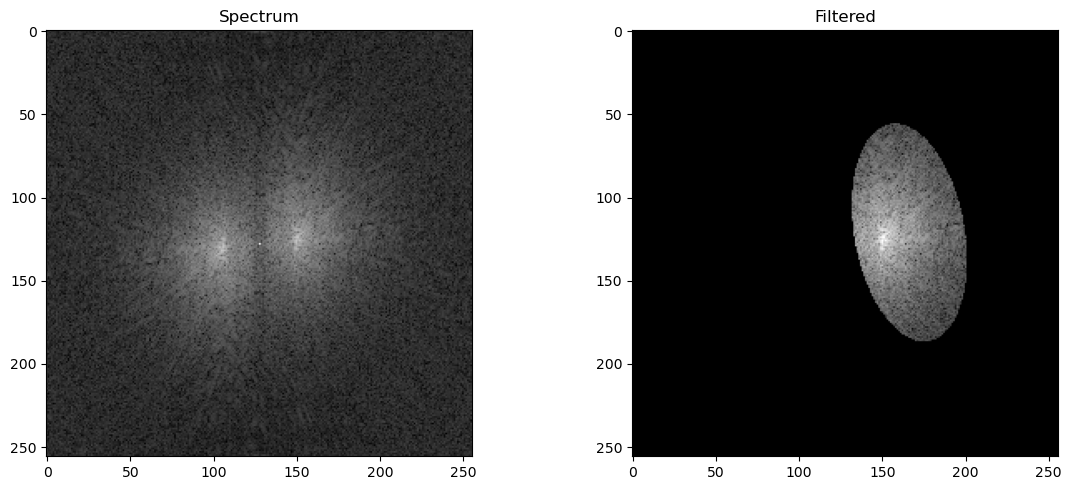

In [69]:
# Display results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(spec, 'gray')
plt.title("Spectrum")

plt.subplot(1, 2, 2)
plt.imshow(spec_flt, 'gray')
plt.title("Filtered")
plt.tight_layout()
plt.show()

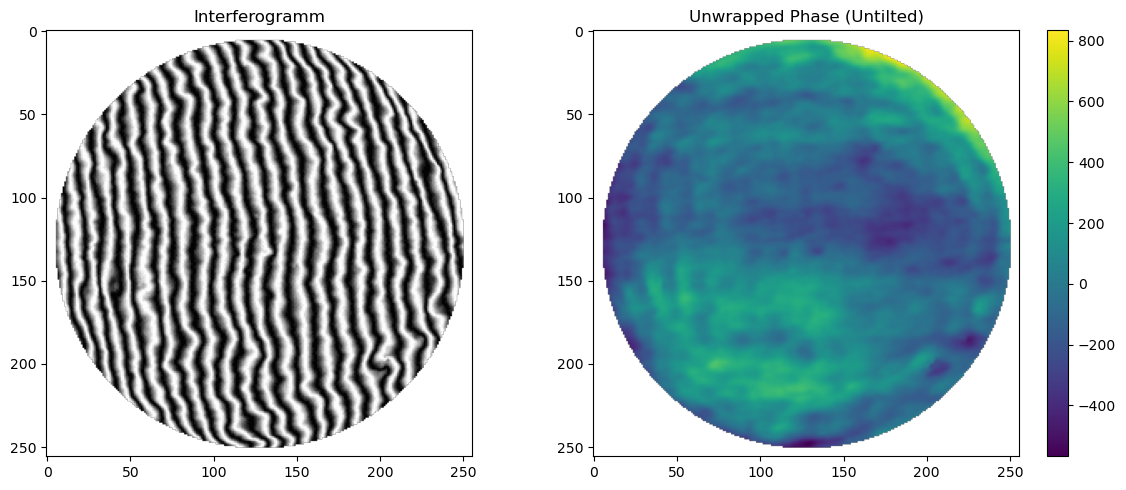

In [70]:
# Scale the phase to nm
unwrapped_phase = scale_phase(unwrapped_phase, 2*np.pi/632.8) # wavefront in nanometers

# Remove tilt before display
untilted_phase = remove_tilt(unwrapped_phase, mask=aperture_mask)

# Display results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Interferogramm")

plt.subplot(1, 2, 2)
plt.imshow(untilted_phase)
plt.title("Unwrapped Phase (Untilted)")
plt.colorbar()
plt.tight_layout()
plt.show()

(<Figure size 640x480 with 2 Axes>, <Axes: >)

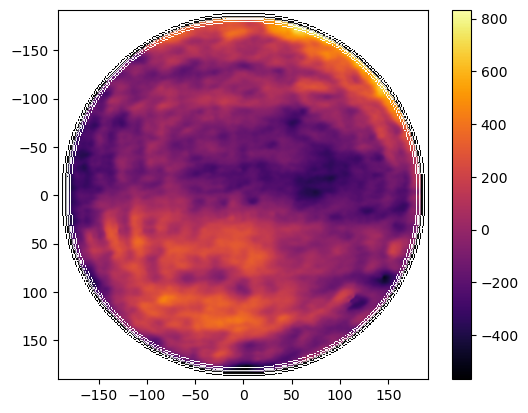

In [71]:
phase = unwrapped_phase.copy()
interf = Interferogram(phase, 1.5, 0.6328)
#interf.mask(circle(200, interf.r))
#interf.crop()
interf.remove_piston()
interf.remove_tiptilt()
interf.plot2d()

In [72]:
(1873.1588, 1309.8695650555728, 183.02083)
interf.pv, interf.pvr(), interf.rms # units are nm

(np.float64(1401.461332550485),
 np.float64(1681.4619434847007),
 np.float64(184.2373119808637))

(<Figure size 640x480 with 2 Axes>, <Axes: >)

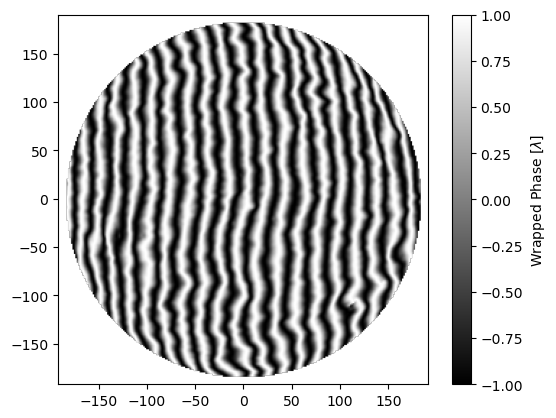

In [73]:
phase_flipped = np.flipud(phase)  # Flip vertically
wave = Interferogram(phase_flipped, dx=1.5, wavelength=0.6328)
#wave.crop()
wave.interferogram(tilt_waves=(10,0))

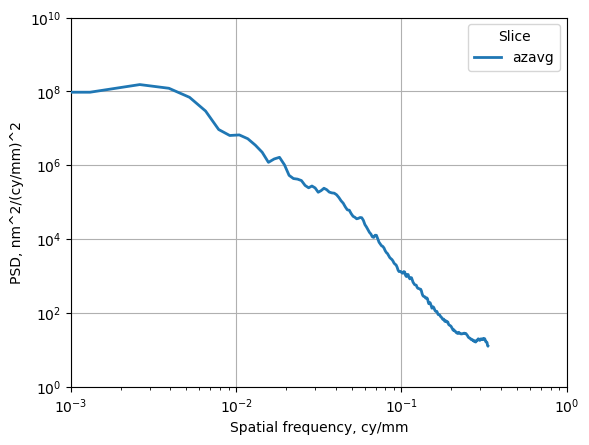

In [74]:
scratch2 = interf.copy()
scratch2.fill()
psd_no_filter = scratch2.psd()

fig, ax = psd_no_filter.slices().plot('azavg')
ax.set(xlabel='Spatial frequency, cy/mm', ylabel='PSD, nm^2/(cy/mm)^2', yscale='log', xscale='log', ylim=(1,1e10), xlim=(1e-3,1))
ax.grid(True)

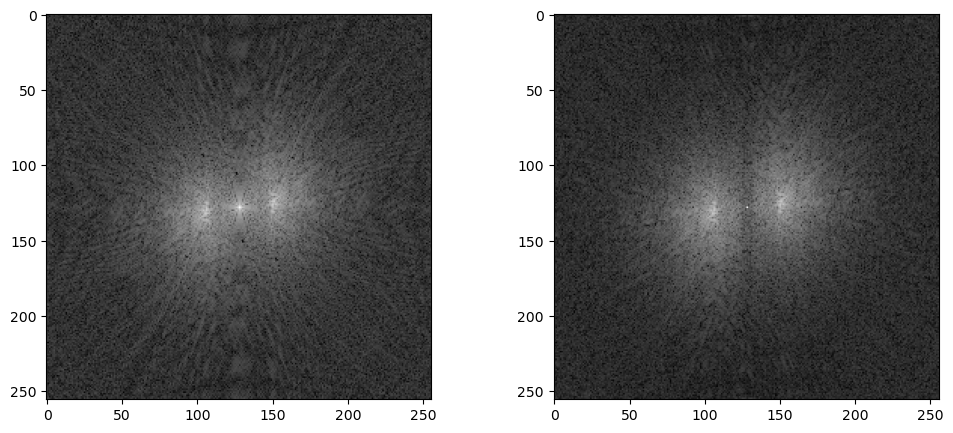

In [75]:
img_path = 'Silicon_asf-Diam~340.jpg'  # Replace with your image path
#img_path = '2025-04-22_08-41-38.png'
img = load_image_grayscale(img_path)

img, aperture_mask = apply_elliptical_mask(img, fill_value=0, a = 0.96, b = 0.96)
_, spectrum, _ = fft_filter_manual(img)
img, aperture_mask = apply_elliptical_mask(img, fill_value=np.nan, a = 0.96, b = 0.96)
_, spectrum_nan, _ = fft_filter_manual(img)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(spectrum, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(spectrum_nan, cmap='gray')
plt.show()

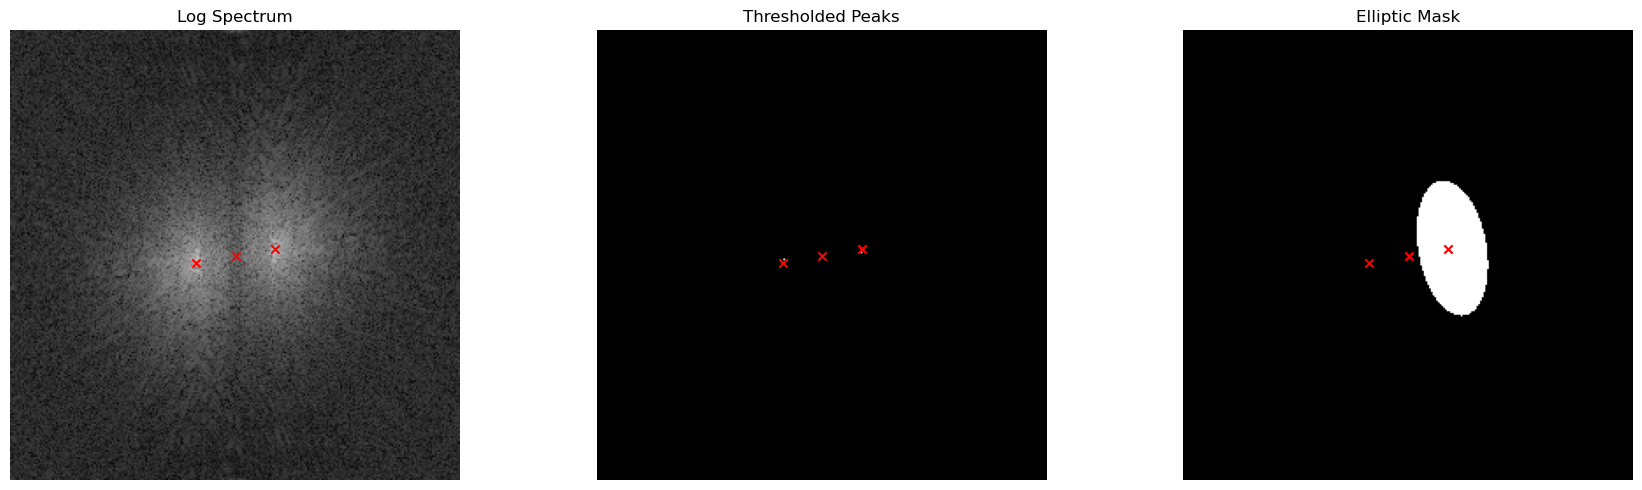

In [76]:
_, mask = auto_frequency_mask(spectrum_nan, debug=True)

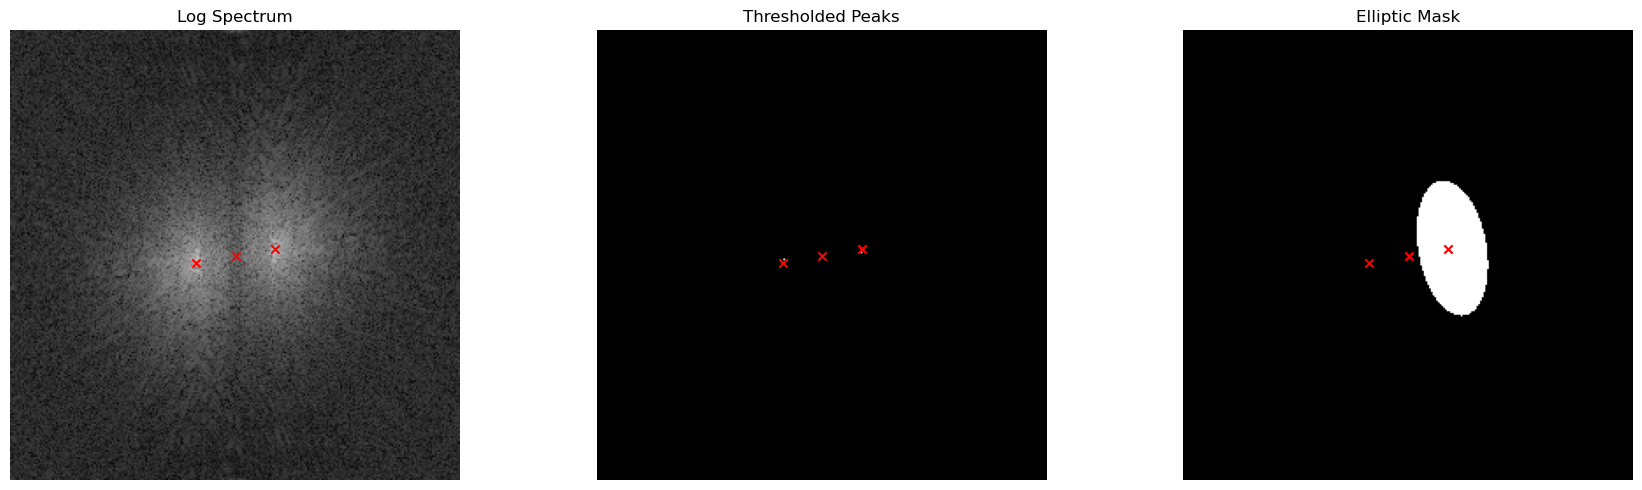

In [79]:
log_spectrum = spectrum_nan
threshold_percentile=98.5
shift_factor=0.1
aspect_ratio=2
debug=True

from scipy.ndimage import label
from skimage.measure import regionprops
from scipy.spatial.distance import euclidean

h, w = log_spectrum.shape
Y, X = np.mgrid[0:h, 0:w]

spectrum = log_spectrum - np.nanmin(log_spectrum)
spectrum /= np.nanmax(spectrum)

# Adaptive threshold search
low, high = 80, 99.99
for _ in range(30):
    threshold = np.percentile(spectrum, threshold_percentile)
    binary = spectrum > threshold
    labeled, num_features = label(binary)

    if num_features == 3:
        break
    elif num_features < 3:
        high = threshold_percentile
        threshold_percentile = (low + threshold_percentile) / 2
    else:
        low = threshold_percentile
        threshold_percentile = (threshold_percentile + high) / 2
    #else: # try finding two side features
        #raise RuntimeError("Failed to isolate nither 3 nor 2 peaks in the frequency domain.")

props = sorted(regionprops(labeled, intensity_image=spectrum), key=lambda r: -r.max_intensity)
peak_coords = np.array([p.weighted_centroid for p in props[:3]])

fit = np.polyfit(peak_coords[:, 1], peak_coords[:, 0], 1)
angle_rad = np.arctan(fit[0])
angle_deg = np.degrees(angle_rad)

cx, cy = w // 2, h // 2
dists = [np.hypot(x - cx, y - cy) for y, x in peak_coords]
center_idx = np.argmin(dists)
lateral_candidates = [i for i in range(3) if i != center_idx]
right_idx = max(lateral_candidates, key=lambda i: peak_coords[i][1])
target_y, target_x = peak_coords[right_idx]
center_y, center_x = peak_coords[center_idx]

# Distance and direction
dlc = euclidean((center_x, center_y), (target_x, target_y))
dx = (target_x - center_x) / dlc
dy = (target_y - center_y) / dlc

# Your preferred logic for mask size and position
minor_radius = (0.75 + shift_factor) * dlc
ellipse_cx = center_x + (0.25 * dlc + minor_radius) * dx
ellipse_cy = center_y + (0.25 * dlc + minor_radius) * dy
major_radius = minor_radius * aspect_ratio

# Elliptical mask aligned with direction
ellipse_angle = (angle_deg + 90) % 180
theta = np.radians(ellipse_angle)
cos_t, sin_t = np.cos(theta), np.sin(theta)
Xc = X - ellipse_cx
Yc = Y - ellipse_cy
Xr = Xc * cos_t + Yc * sin_t
Yr = -Xc * sin_t + Yc * cos_t

mask = (Xr / major_radius) ** 2 + (Yr / minor_radius) ** 2 <= 1

if debug:
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    titles = ['Log Spectrum', 'Thresholded Peaks', 'Elliptic Mask']
    images = [log_spectrum, binary, mask]

    for ax, img, title in zip(axs, images, titles):
        ax.imshow(img, cmap='gray')
        ax.scatter(peak_coords[:, 1], peak_coords[:, 0], color='red', marker='x')
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

mask = {
    'center': (ellipse_cx, ellipse_cy),
    'size': (2 * major_radius, 2 * minor_radius),
    'angle_deg': ellipse_angle
}


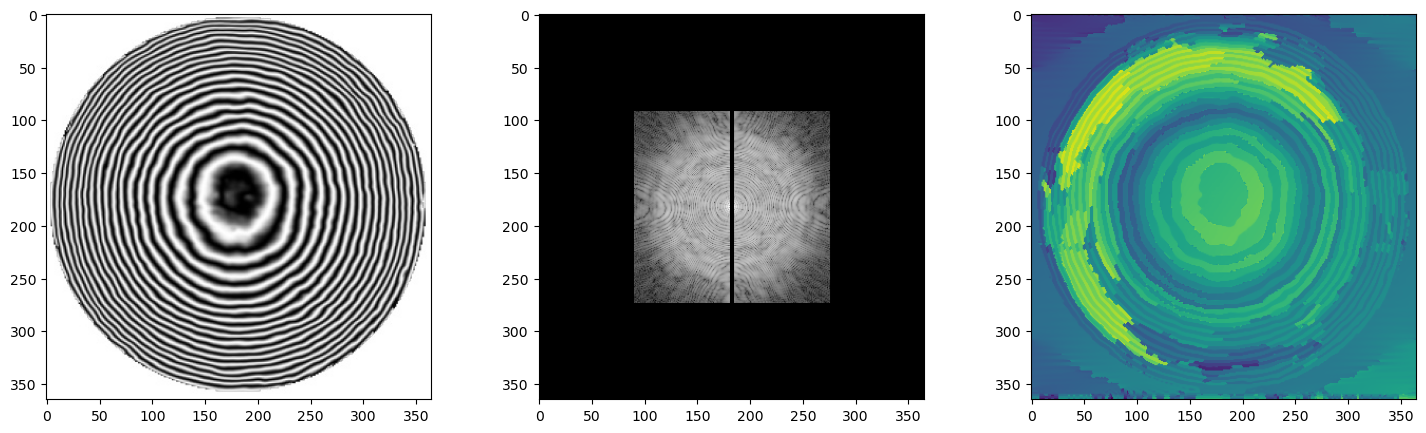

In [ ]:
img_path = 'with-closed-fringes.png'  # Replace with your image path
#img_path = './temp/Silicon_asf-Diam~340-rings.jpg'
#img_path = '2025-04-22_08-41-38.png'
img = load_image_grayscale(img_path)

params = [
    {
        'mask_shape': 'rectangle',
        'center': (-0.26, 0),
        'size': (0.5, 1),
        'angle': 0,
        'invert': False
    },
    {
        'mask_shape': 'rectangle',
        'center': (0.26, 0),
        'size': (0.5, 1),
        'angle': 0,
        'invert': False
    }
]

phase_x, spectrum, spectrum_masked = fft_filter_manual_multy(img, params)
phase_x = remove_tilt(phase_x)
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(spectrum_masked, cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(phase_x)

plt.show()

{'center': (np.float64(152.75530449676387), np.float64(123.6)),
  'size': (77.71562785927858, 38.85781392963929),
  'angle_deg': np.float64(79.92151776786842)}